In [ ]:
# Install library
!pip install lightgbm openpyxl
!pip install seaborn

# Import library
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib
import unicodedata
import re
from graphviz import Digraph

# Fungsi normalisasi teks untuk kolom kategorikal
def bersihkan_teks(teks):
    teks = str(teks)
    teks = unicodedata.normalize('NFKD', teks)            # Normalisasi Unicode
    teks = teks.strip().lower()                           # Hapus spasi & lowercase
    teks = re.sub(r'\s+', ' ', teks)                      # Spasi ganda → 1 spasi
    teks = teks.replace("’", "'").replace("`", "'")       # Smart quote → normal
    teks = teks.replace("“", '"').replace("”", '"')       # Double quote normalize
    teks = re.sub(r"\s*=\s*", " = ", teks)                # Rapikan spasi di sekitar '='
    return teks

# salah ketik / singkatan : bentuk lengkap
    singkatan_dict = {
    "tbl":  "tebal"}

# Load dataset
dataset_path = 'data banjarmasin.xlsx'
df = pd.read_excel(dataset_path)
df.info()

# Tampilkan 5 baris pertama
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Lokasi              429 non-null    object 
 1   jenis pembangunan   429 non-null    object 
 2   Jenis Pekerjaan     429 non-null    object 
 3   Uraian Pekerjaan    429 non-null    object 
 4   Volume              429 non-null    float64
 5   Satuan              429 non-null    object 
 6   Harga Satuan        429 non-null    float64
 7   Jumlah              429 non-null    float64
dtypes: float64(3), object(5)
memory usage: 26.9+ KB


,Lokasi,jenis pembangunan,Jenis Pekerjaan,Uraian Pekerjaan,Volume,Satuan,Harga Satuan,Jumlah
0,Banjarmasin,kelas atau lab,pekerjaan persiapan,pembersihan lokasi sebelum dan sesudah pekerjaan,1.0,ls,1000000.00,1000000.00
1,Banjarmasin,kelas atau lab,pekerjaan persiapan,pembongkaran bangunan,1.0,ls,1500000.00,1500000.00
2,Banjarmasin,kelas atau lab,pekerjaan persiapan,papan nama proyek,1.0,ls,93022.15,93022.15
3,Banjarmasin,kelas atau lab,pekerjaan persiapan,rencana keselamatan dan kesehatan kerja,1.0,ls,500000.00,500000.00
4,Banjarmasin,kelas atau lab,pekerjaan persiapan,pembersihan lokasi sebelum dan sesudah pekerjaan,1.0,ls,650000.00,650000.00


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 343, number of used features: 6
[LightGBM] [Info] Start training from score 10001037.277879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

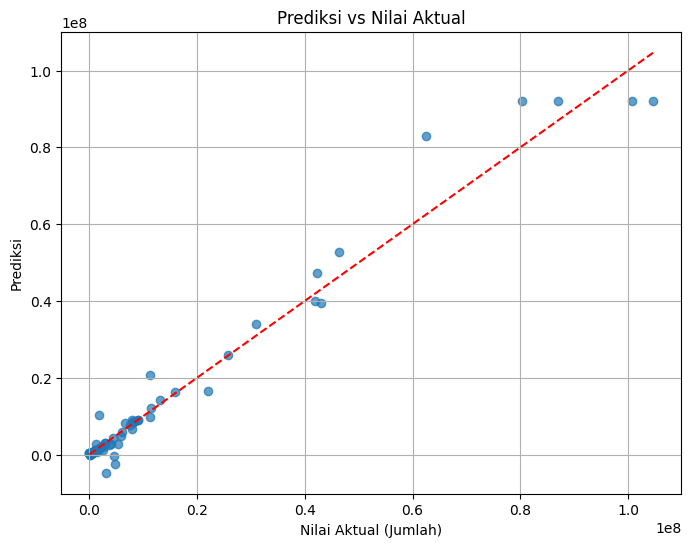

['model_prediksi.model']

In [ ]:
# Bersihkan nama kolom
df.columns = df.columns.str.strip()  # hapus spasi di nama kolom

# Bersihkan data numerik
df['Jumlah'] = df['Jumlah'].replace(',', '', regex=True)
df['Jumlah'] = pd.to_numeric(df['Jumlah'], errors='coerce')

# Normalisasi dan Label Encoding untuk kolom kategorikal (objek)
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(bersihkan_teks)  # ✅ Gunakan fungsi bersih
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Hapus baris yang mengandung NaN
df = df.dropna()

# Pisahkan fitur dan target
X = df.drop(['Jumlah'], axis=1)
y = df['Jumlah']

# Split data ke training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training model LightGBM
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Plot hasil prediksi vs aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Nilai Aktual (Jumlah)')
plt.ylabel('Prediksi')
plt.title('Prediksi vs Nilai Aktual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()

# Simpan semua LabelEncoder
for col, le in label_encoders.items():
    joblib.dump(le, f"le_{col}.joblib")

# Simpan model
joblib.dump(model, "model_prediksi.model")

In [ ]:
# Prediksi dan evaluasi
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 1736931.78
RMSE: 3844239.81
R²: 0.9688


In [ ]:
df.head()

,Lokasi,jenis pembangunan,Jenis Pekerjaan,Uraian Pekerjaan,Volume,Satuan,Harga Satuan,Jumlah
0,0,1,6,60,1.0,3,1000000.00,1000000.00
1,0,1,6,61,1.0,3,1500000.00,1500000.00
2,0,1,6,41,1.0,3,93022.15,93022.15
3,0,1,6,69,1.0,3,500000.00,500000.00
4,0,1,6,60,1.0,3,650000.00,650000.00


In [ ]:
# Tampilkan nilai unik dan jumlah kemunculan di kolom-kolom kategori
kode_kolom = ['Kota', 'Lokasi', 'jenis pembangunan', 'Jenis Pekerjaan', 'Uraian Pekerjaan', 'Satuan']

for kolom in kode_kolom:
    print(f"\nKolom: {kolom}")
    print(df[kolom].value_counts().sort_index())


Kolom: Kota
Kota
0    429
1    895
Name: count, dtype: int64

Kolom: Lokasi
Lokasi
0     429
1     313
2      65
3      42
4      48
5      50
6      81
7     182
8      62
9       2
10     50
Name: count, dtype: int64

Kolom: jenis pembangunan
jenis pembangunan
0    212
1    671
2     64
3    232
4     68
5     77
Name: count, dtype: int64

Kolom: Jenis Pekerjaan
Jenis Pekerjaan
0       2
1      56
2      18
3     208
4      36
5      14
6      26
7      33
8       1
9      48
10     12
11     30
12     57
13     13
14      4
15      8
16     66
17     32
18     30
19     59
20    131
21     51
22     38
23      7
24      1
25     53
26     51
27     69
28      5
29     16
30    149
Name: count, dtype: int64

Kolom: Uraian Pekerjaan
Uraian Pekerjaan
0      26
1      13
2      10
3      10
4      10
       ..
395     4
396    10
397     3
398     5
399    10
Name: count, Length: 399, dtype: int64

Kolom: Satuan
Satuan
0      54
1     328
2      11
3       5
4      59
5      11
6     1

In [ ]:
df.head()

,Kota,Lokasi,jenis pembangunan,Jenis Pekerjaan,Uraian Pekerjaan,Volume,Satuan,Harga Satuan,Jumlah
0,1,7,1,20,310,238.0730,8,10516.75,2.503754e+06
1,1,7,1,20,309,74.5725,8,14081.75,1.050111e+06
2,1,7,1,20,142,1.0000,6,125000.00,1.250000e+05
3,1,3,1,20,309,24.0000,8,35650.00,8.556000e+05
4,1,3,1,20,142,1.0000,6,174154.75,1.741548e+05


In [ ]:
import joblib
import os

# ── 1. Tentukan nama file encoder untuk setiap kolom ────────────────────────────
encoder_files = {
    'Kota'              : 'le_Kota.joblib',
    'Lokasi'            : 'le_Lokasi.joblib',
    'jenis pembangunan' : 'le_jenis pembangunan.joblib'
    'Jenis Pekerjaan'   : 'le_Jenis Pekerjaan.joblib',
    'Uraian Pekerjaan'  : 'le_Uraian Pekerjaan.joblib',
    'Satuan'            : 'le_Satuan.joblib'
}

# ── 2. Fungsi penolong untuk menampilkan mapping ───────────────────────────────
def show_mapping(col_name, file_name):
    if not os.path.exists(file_name):
        print(f"[!] File encoder untuk kolom '{col_name}' tidak ditemukan: {file_name}")
        return

    le = joblib.load(file_name)
    mapping = {i: label for i, label in enumerate(le.classes_)}

    print(f"\n=== Mapping kolom '{col_name}' ===")
    for k, v in mapping.items():
        print(f"{k:>4} → {v}")

    return le  # kembalikan encoder jika perlu digunakan lagi

# ── 3. Cetak mapping semua kolom kategori ──────────────────────────────────────
encoders = {}  # simpan encoder kalau mau dipakai lagi
for col, file in encoder_files.items():
    encoders[col] = show_mapping(col, file)

# ── 4. Contoh: ambil arti kode tertentu ────────────────────────────────────────
# Ganti angka_kode sesuai kebutuhan
angka_kode = 0
col_target = 'jenis pembangunan'

le_target = encoders[col_target]  # ambil dari dict encoders di atas
if le_target is not None:
    arti_kode = le_target.inverse_transform([angka_kode])[0]




=== Mapping kolom 'Kota' ===
   0 → banjarmasin
   1 → tanjung

=== Mapping kolom 'Lokasi' ===
   0 → banjarmasin
   1 → kabupaten tabalong
   2 → kec. banua lawas
   3 → kec. haruai
   4 → kec. jaro kabupaten tabalong
   5 → kec. muara uya
   6 → kec. pugaan kabupaten tabalong
   7 → kec. tanjung kabupaten tabalong
   8 → kec. tanta kabupaten tabalong
   9 → kec.banua lawas
  10 → murung pudak

=== Mapping kolom 'jenis pembangunan' ===
   0 → halaman
   1 → kelas atau lab
   2 → mushalla
   3 → rehab
   4 → rkb 6x8
   5 → wc

=== Mapping kolom 'Jenis Pekerjaan' ===
   0 → mobilisasi
   1 → pekerjaan atap
   2 → pekerjaan atap dan plafond
   3 → pekerjaan beton
   4 → pekerjaan cat-catan
   5 → pekerjaan daun pintu, jendela
   6 → pekerjaan dinding
   7 → pekerjaan dinding dan penutup lantai
   8 → pekerjaan dinding kayu ulin
   9 → pekerjaan elektrikal & elektronik
  10 → pekerjaan finishing
  11 → pekerjaan halaman
  12 → pekerjaan instalasi listrik
  13 → pekerjaan instalasi sanita

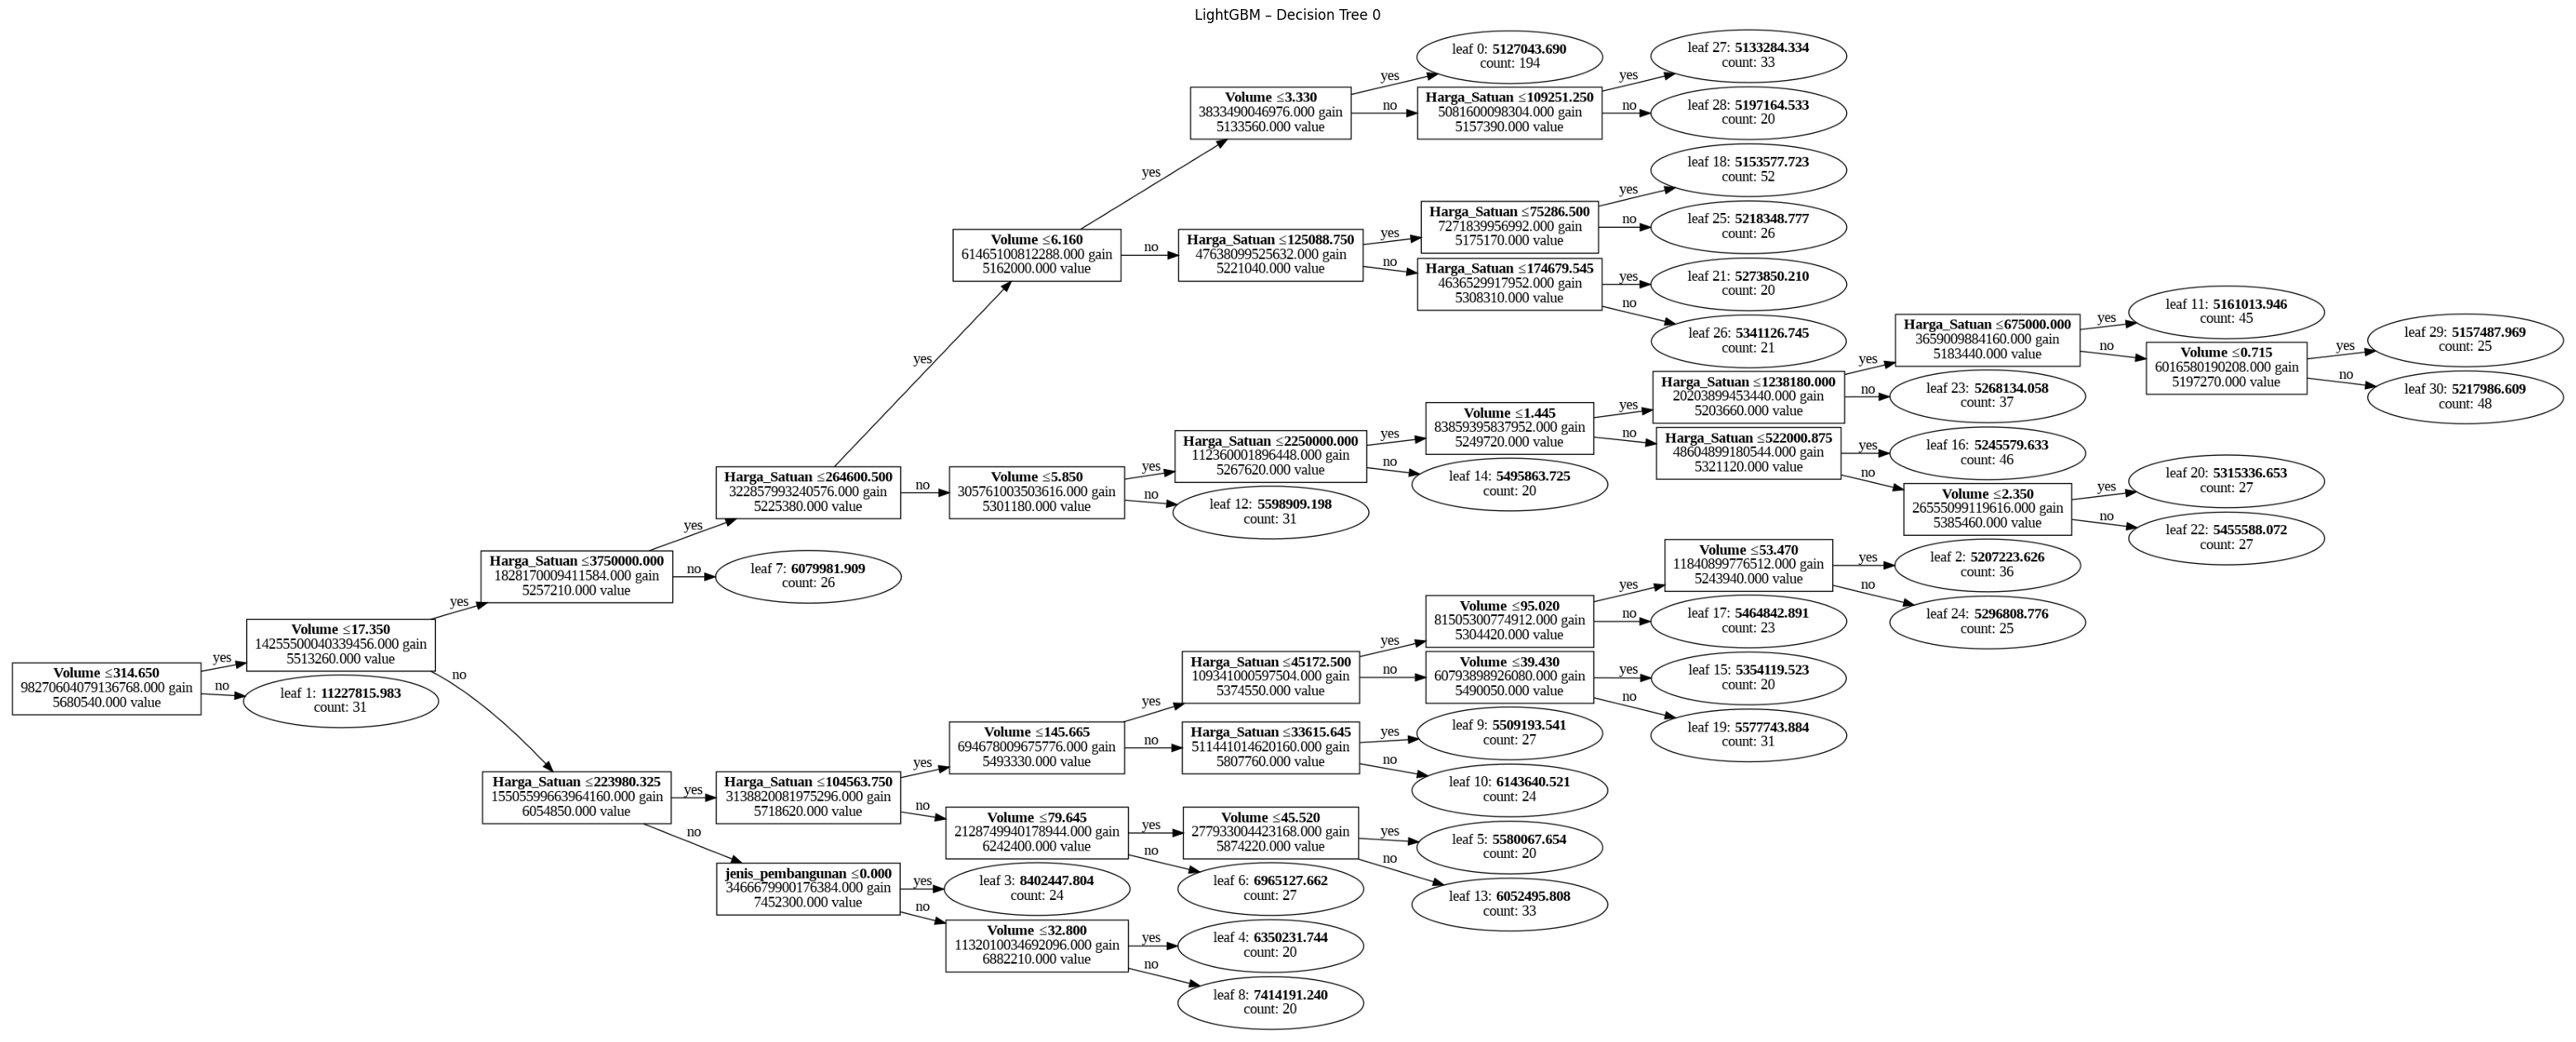

In [ ]:
# ── Plot satu pohon (mis. pohon ke‑0) ───────────────────────────────
ax = lgb.plot_tree(
        model,                 # model LightGBM yang sudah dilatih
        tree_index=0,          # indeks pohon (0 = pohon pertama)
        figsize=(40, 20),      # ukuran kanvas (sesuaikan)
        show_info=[
            'split_gain',      # tampilkan gain pada setiap node
            'internal_value',  # nilai di node internal
            'leaf_count'       # jumlah data di tiap daun
        ]
)
plt.title("LightGBM – Decision Tree 0")
plt.show()

In [ ]:
# Fungsi built‑in LightGBM
dot = lgb.create_tree_digraph(
        model,
        tree_index=0,
        name="Tree0",
        show_info=['split_gain', 'internal_value', 'leaf_count']
)
dot.format = 'png'             # atau 'pdf'
dot.render("tree0")            # hasil → tree0.png di folder kerja

'tree0.png'